In [1]:
import os
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import seaborn as sns

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# path with scPerturb data
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
# path for figures
figure_path = '../../figures/'

# Load Data

In [2]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
# exclude protein datasets
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
# exclude scATAC-seq datasets
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']
# buggy?
del h5_files['XieHon2017']

datasets = list(h5_files.keys())
print(len(datasets))

34


In [3]:
# capture obs and vars in a dict, indices as keys
obses = {}
vares = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
    vares[name] = pd.read_csv(os.path.dirname(path)+'/var.csv')

  0%|          | 0/34 [00:00<?, ?it/s]

In [4]:
# This is the excel table on the datasets
metadata = pd.read_csv('../../tables/publicly_available_singlecell_perturbation_data_25072022.csv', index_col=0)
metadata.keys()

Index(['Title', 'doi/url', 'First author', 'Selected other authors',
       'Corresponding Emails', 'Organisms', 'Modality = Data type', 'Method',
       'Sequencer', 'Library construction', 'data access', 'GSE', 'Tissues',
       'Perturbation', 'Leukemia', 'Solid Cancer', 'Notes',
       '# samples, cells or runs', 'multiple time points?',
       'multiple concentrations?', 'combined perturbations?',
       'Date of Submission', 'sgRNA library', 'Download status',
       'Mini-Abstract (loosely summarized original Abstract)'],
      dtype='object')

# Prepare and aggregate QC

In [5]:
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange',
    'CRISPR-cas9': 'tab:orange',
    'drug': 'tab:green',
    'cytokine': 'tab:olive'
}

In [6]:
# handle obs

cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)

# sort
obses = {key: obses[key] for key in np.sort(list(obses.keys()))} 

B=pd.DataFrame({name: [list(pd.unique(obs[key]))[0] if key in obs.keys() else None for key in cat_obs_keys] for name, obs in obses.items()}, index=cat_obs_keys).T

B.loc['XieHon2017', 'celltype'] = 'lymphoblasts'
B.loc['McFarlandTshemiak2020_all_expts_combined', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'celltype'] = 'lymphoblasts'
B.loc['WeinrebKlein2020', 'cell_line'] = 'Mo'
B.loc['ChangYe2021', 'celltype'] = 'epithelial'
B.loc['FrangiehIzar2021_RNA', 'tissue_type'] = 'cell_line'
B.loc['ChangYe2021', 'tissue_type'] = 'cell_line'

B.celltype = B.celltype.replace({'iPSC-induced neuron': 'iPSC neurons', 'iPSC': 'iPSC neurons', 'alveolar basal epithelial cells': 'epithelial', 'mammary epithelial cells': 'epithelial'})
B.celltype = B.celltype.replace({'monocytes': 'mono- cytes', 'lymphoblasts': 'lympho- blasts', 'melanocytes': 'melano- cytes', 'epithelial': 'epi- thelial'})
B.disease = B.disease.replace({'acute monocytic leukemia': 'AMoL', 'myelogenous leukemia': 'AML', 'chronic myelogenous leukemia': 'CML', 'acute T cell leukemia': 'T-ALL',
                              'lung adenocarcinoma': 'lung AC', 'breast adenocarcinoma': 'breast AC'})
B.disease = B.disease.replace({'melanoma': 'mela- noma', 'glioblastoma': 'glio- blastoma'})

B.loc['TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
B.loc['TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
B.loc['TianKampmann2019_iPSC', 'perturbation_type'] = 'CRISPRi'
B.loc['TianKampmann2019_day7neuron', 'perturbation_type'] = 'CRISPRi'

# B=B.rename({'PapalexiSatija2021_eccite_arrayed_RNA' : 'PapalexiSatija2021_arrayed',
#                  'PapalexiSatija2021_eccite_RNA' : 'PapalexiSatija2021',
#                  'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTshemiak2020',
#                  'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen': 'SchraivogelSteinmetz2020_Chr11',
#                  'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen': 'SchraivogelSteinmetz2020_Chr8',
#                  'AdamsonWeissman2016_GSM2406677_10X005': 'AdamsonWeissman2016_10X005',
#                  'AdamsonWeissman2016_GSM2406681_10X010': 'AdamsonWeissman2016_10X010',
#                  'AdamsonWeissman2016_GSM2406675_10X001': 'AdamsonWeissman2016_10X001'
#                 })
                
cpalette = {d: colors_perturbation_types[B.loc[d, 'perturbation_type']] for d in obses.keys()}
B.head()

,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype
AdamsonWeissman2016_GSM2406675_10X001,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_GSM2406677_10X005,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AdamsonWeissman2016_GSM2406681_10X010,CRISPR,human,cell_line,K562,True,CML,lympho- blasts
AissaBenevolenskaya2021,drug,human,cell_line,PC9_xenograft,True,NaN,NaN
ChangYe2021,drug,human,cell_line,None,True,lung AC,epi- thelial


In [7]:
# handle vars
vares = {key: vares[key] for key in np.sort(list(vares.keys()))}  # sort 

In [8]:
# delete datasets from obses where the column 'ncounts' is missing
K = list(obses.keys())
for name in K:
    if 'ncounts' not in obses[name].columns:
        print(name)
        del obses[name]
# delete datasets from vares where the column 'ncounts' is missing
K = list(vares.keys())
for name in K:
    if 'ncounts' not in vares[name].columns:
        print(name)
        del vares[name]

AissaBenevolenskaya2021
DixitRegev2016
AissaBenevolenskaya2021
DixitRegev2016


In [9]:
## Obs
# collect numerical data for cells per dataset
num_obs_keys = ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', # numerical vector
                'perturbation_type' # and annotations
               ]  
# for obs_key in num_obs_keys:
ddict = {name: obs[num_obs_keys] for name, obs in obses.items()}
df = pd.concat(ddict).reset_index(level=0)
df.columns = ['dataset'] + num_obs_keys

## Var
num_var_keys = ['ncounts', 'ncells']  # numerical vector
num_data = []
for var_key in num_var_keys:
    num_data.append([var[var_key].values for name, var in vares.items()])
    
# for obs_key in num_obs_keys:
ddict = {name: var[num_var_keys] for name, var in vares.items()}
df_ = pd.concat(ddict).reset_index(level=0)
df_.columns = ['dataset'] + num_var_keys

# Fig3A

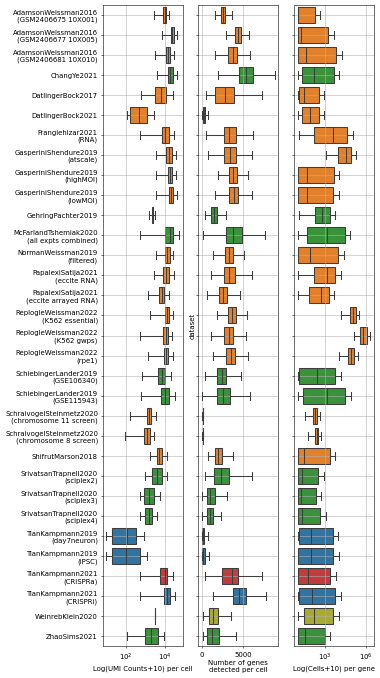

In [10]:
# options
color = 'perturbation_type'
palette = cpalette
pseudocounts = 10

# setup figure
# with sns.axes_style("whitegrid"):
fig, axs = pl.subplots(1, 3, figsize=[7, 17], sharey=True, dpi=50)

# First row ncounts (obs)
ax = axs[0]
df['ncounts'] += pseudocounts
sns.boxplot(data=df, y='dataset', x='ncounts', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel(f'Log(UMI Counts+{pseudocounts}) per cell')
ax.set_xscale('log')
# ax.set_title('UMI Counts')
ax.grid()

# Second row ngenes
ax = axs[1]
sns.boxplot(data=df, y='dataset', x='ngenes', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel('Number of genes\ndetected per cell')
# ax.set_title('Genes Expressed')
ax.grid()

# Third row ngenes
ax = axs[2]
df_['ncells'] += pseudocounts
sns.boxplot(data=df_, y='dataset', x='ncells', showfliers=False, ax=ax, zorder=5, color=color, palette=palette)
ax.set_xlabel(f'Log(Cells+{pseudocounts}) per gene')
ax.set_xscale('log')
ax.grid()
    
# xticks and labels
dataset_names = obses.keys()
dataset_names = [x.replace('TAP_SCREEN__', '') for x in dataset_names]
dataset_names = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dataset_names]
dataset_names = [x.replace('_', ' ') for x in dataset_names]
axs[-1].set_yticks(np.arange(len(dataset_names)))
axs[-1].set_ylabel('')
axs[-1].set_yticklabels(dataset_names, rotation=90)
axs[0].set_ylabel('')
pl.savefig(f'{figure_path}/Fig3A.pdf', bbox_inches='tight')
pl.show()

# Fig3C

In [11]:
tab = pd.DataFrame(index=obses.keys())
for name, obs in obses.items():
    # print(name)
    tab.loc[name, 'mean counts per cell'] = np.mean(obs.ncounts)
    tab.loc[name, 'mean genes expressed per cell'] = np.mean(obs.ngenes)
    tab.loc[name, 'number of perturbations'] = len(pd.unique(obs.perturbation))
    tab.loc[name, 'number of perturbations (log)'] = np.log(len(pd.unique(obs.perturbation)))
    tab.loc[name, 'number of cells'] = len(obs)
    tab.loc[name, 'mean number of cells per perturbation'] = np.mean(obs.value_counts('perturbation'))
    tab.loc[name, 'modality'] = 'protein' if 'protein' in name else 'RNA'
    sname = name.split('_')[0]
    sname = 'McFarlandTsherniak2020' if 'McFarland' in sname else sname
    tab.loc[name, 'year'] = int(sname[-4:])
    tab.loc[name, 'Date of Submission'] = pd.to_datetime(metadata.loc[sname, 'Date of Submission'])
    for cat_key in ['tissue_type', 'cancer', 'organism', 'perturbation_type']:
        tab.loc[name, cat_key] = pd.unique(obs[cat_key])[0] if cat_key in obs.keys() else None
    tab.loc[name, 'dataset'] = name

tab['perturbation_type'][tab.perturbation_type=='CRISPR'] = 'CRISPR-cas9'
tab.loc['TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
tab.loc['TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
tab.loc['TianKampmann2019_iPSC', 'perturbation_type'] = 'CRISPRi'
tab.loc['TianKampmann2019_day7neuron', 'perturbation_type'] = 'CRISPRi'
tab = tab.rename({'perturbation_type': 'perturbation type'}, axis=1)

In [12]:
tab

,mean counts per cell,mean genes expressed per cell,number of perturbations,number of perturbations (log),number of cells,mean number of cells per perturbation,modality,year,Date of Submission,tissue_type,cancer,organism,perturbation type,dataset
AdamsonWeissman2016_GSM2406675_10X001,10166.141817,2557.463592,10.0,2.302585,5768.0,639.777778,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR-cas9,AdamsonWeissman2016_GSM2406675_10X001
AdamsonWeissman2016_GSM2406677_10X005,25340.052512,4235.199187,21.0,3.044522,15006.0,735.500000,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR-cas9,AdamsonWeissman2016_GSM2406677_10X005
AdamsonWeissman2016_GSM2406681_10X010,15915.297580,3639.789813,115.0,4.744932,65337.0,550.210526,RNA,2016.0,2019-10-01,cell_line,True,human,CRISPR-cas9,AdamsonWeissman2016_GSM2406681_10X010
ChangYe2021,22044.779573,5439.283629,4.0,1.386294,42277.0,10569.250000,RNA,2021.0,2021-08-01,None,True,human,drug,ChangYe2021
DatlingerBock2017,8567.240982,2789.345470,97.0,4.574711,5905.0,60.876289,RNA,2017.0,2016-12-01,cell_line,True,human,CRISPR-cas9,DatlingerBock2017
DatlingerBock2021,957.881436,273.351508,48.0,3.871201,39194.0,816.541667,RNA,2021.0,2019-12-01,cell_line,True,human,CRISPR-cas9,DatlingerBock2021
FrangiehIzar2021_RNA,12700.372815,3392.721345,249.0,5.517453,218331.0,876.831325,RNA,2021.0,2020-08-01,cell_line_co-culture,True,human,CRISPR-cas9,FrangiehIzar2021_RNA
GasperiniShendure2019_atscale,18171.176834,3371.526268,203496.0,12.223402,207324.0,1.011312,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR-cas9,GasperiniShendure2019_atscale
GasperiniShendure2019_highMOI,19305.300147,3675.874334,39088.0,10.573571,47650.0,1.211426,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR-cas9,GasperiniShendure2019_highMOI
GasperiniShendure2019_lowMOI,22108.307698,3755.207175,16532.0,9.713053,41284.0,2.226786,RNA,2019.0,2018-06-01,cell_line,True,human,CRISPR-cas9,GasperiniShendure2019_lowMOI


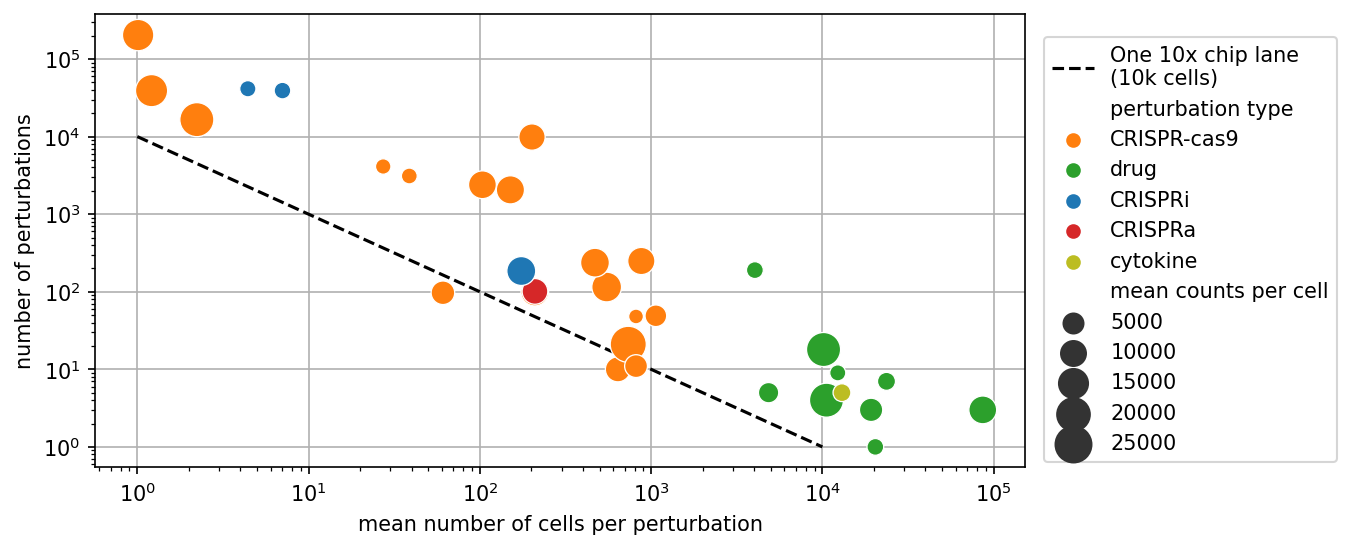

In [13]:
fig, ax = pl.subplots(figsize=[8,4], dpi=150)
sns.scatterplot(data=tab, x='mean number of cells per perturbation', y='number of perturbations', palette=colors_perturbation_types,
                hue='perturbation type', size='mean counts per cell', sizes=(50,300), zorder=3)
ax.plot([1, 1e4], [1e4, 1], 'k--', label='One 10x chip lane\n(10k cells)')
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
# pl.title('Trade-off between number of perturbations and\nmean cells per perturbation')
pl.savefig(f'{figure_path}/Fig3C.pdf', bbox_inches='tight')
pl.show()